In [87]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from cfl.visualization.basic_visualizations import visualize_macrostates
from sklearn.preprocessing import StandardScaler
from cfl_helpers import *

In [88]:
resolution = '40km'
train_file = f'data/{resolution}_data.csv'
truth_file = f'data/{resolution}_truth.csv'

train_data = pd.read_csv(train_file)
Xraw = np.array(train_data[['lat', 'long']])
Yraw = np.array(train_data['generated_temp']).reshape(-1,1)
print(Xraw.shape, Yraw.shape)

truth = pd.read_csv(truth_file)
true_alt, true_temp = get_alt_temp_grids(truth)

(833, 2) (833, 1)


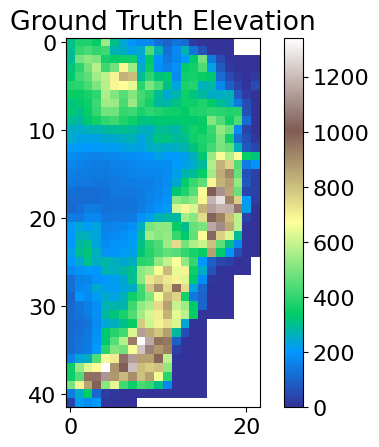

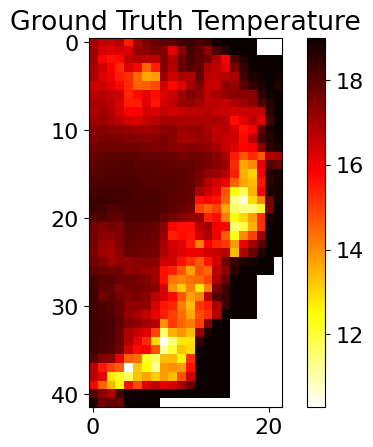

In [89]:
# PLOT TEMP AND ELEVATION FOR RAW DATAFRAME
plt.figure(1)
plt.imshow(true_alt, cmap='terrain', interpolation='nearest')
plt.colorbar()
plt.title('Ground Truth Elevation')
plt.show()

plt.figure(2)
plt.imshow(true_temp, cmap='hot_r', interpolation='nearest')
plt.colorbar()
plt.title('Ground Truth Temperature')
plt.show()

In [90]:
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)

In [91]:
# Create 3 dictionaries: one for data info, one with CDE parameters, and one with cluster parameters

# the parameters should be passed in dictionary form
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

# pass in empty parameter dictionaries to use the default parameter values (not
# allowed for data_info)
CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 64,
                    'n_epochs'    : 2500,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 1,
                    'show_plot'   : True,
                }
}

# cluster_params consists of specifying two clustering objects
# CFL automatically recognizes the names of all sklearn.cluster models as keywords
cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : 500},
                         'verbose' : 0
}

In [92]:
# block_names indicates which CDE and clustering models to use
block_names = ['CondDensityEstimator', 'CauseClusterer']

# block_params is aligned to block_names
block_params = [CDE_params, cause_cluster_params]

results_path = 'sample_run' # directory to save results to

# Create a new CFL experiment with specified parameters
my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)

All results from this run will be saved to sample_run\experiment0011
Block: verbose not specified in input, defaulting to 1
CondExpBase: activity_regularizers not specified in input, defaulting to None
CondExpBase: kernel_regularizers not specified in input, defaulting to None
CondExpBase: bias_regularizers not specified in input, defaulting to None
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: weights_path not specified in input, defaulting to None
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: checkpoint_name not specified in input, defaulting to tmp_checkpoints


#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Epoch 1/2500
10/10 [==============================] - 0s 15ms/step - loss: 2.7786 - val_loss: 2.8024
Epoch 2/2500
10/10 [==============================] - 0s 6ms/step - loss: 2.7312 - val_loss: 2.7568
Epoch 3/2500
10/10 [==============================] - 0s 7ms/step - loss: 2.6844 - val_loss: 2.7122
Epoch 4/2500
10/10 [==============================] - 0s 7ms/step - loss: 2.6391 - val_loss: 2.6683
Epoch 5/2500
10/10 [==============================] - 0s 9ms/step - loss: 2.5945 - val_loss: 2.6255
Epoch 6/2500
10/10 [==============================] - 0s 7ms/step - loss: 2.5497 - val_loss: 2.5842
Epoch 7/2500
10/10 [==============================] - 0s 7ms/step - loss: 2.5071 - val_loss: 2.5432
Epoch 8/2500
10/10 [==============================] - 0s 6ms/step - loss: 2.4654 - val_loss: 2.5025
Epoch 9/2500
10/10 [==============================] - 0

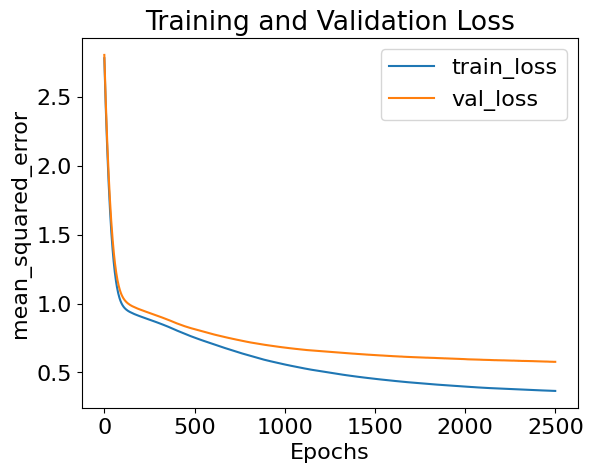

27/27 [==============================] - 0s 530us/step
Loading parameters from  tmp_checkpoints31012025161213\best_weights
Saving parameters to  sample_run\experiment0011\trained_blocks\CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [93]:
results = my_exp.train()

# Reconstruct the elevation map based on labels

# LOOK IN DATA, POINTS ARE GROUPED BY LAT

In [94]:
xlbls = results['CauseClusterer']['x_lbls']

print(len(xlbls))

833


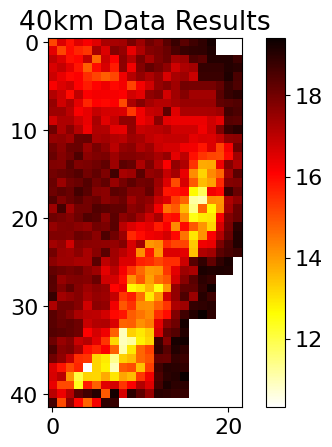

In [95]:
reconstruct_temps = reconstruct_groups(train_data, xlbls, title=f'{resolution} Data Results')

# WANT TO CLASSIFY ACCURACY

In [96]:
def by_cluster_abs_err(data, xlbls, truth):
    pred_group_avgs, _ = get_group_avgs(data, xlbls)
    _, true_groups = get_group_avgs(truth, xlbls)
    abs_err = 0

    for group in pred_group_avgs.keys():
        true_temps = np.array(true_groups[group])
        pred_temp = pred_group_avgs[group]
        abs_err += np.sum(np.abs(true_temps - pred_temp))
    
    return abs_err

In [97]:
cluster_abs_error = by_cluster_abs_err(train_data, xlbls, truth)
print(cluster_abs_error)

{0: 17.0318949975, 1: 18.279877826666667, 2: 14.1099457725, 3: 18.68574723, 4: 18.14445053835, 5: 15.608373385, 6: 19.0, 7: 15.306687195, 8: 17.558313783714283, 9: 18.2544045975, 10: 11.6377373, 11: 17.399487645, 12: 18.2975216, 13: 12.6985412, 14: 15.933312675, 15: 19.0, 16: 17.180563615, 17: 19.0, 18: 17.1418915972, 19: 17.77078097, 20: 18.4083115, 21: 19.0, 22: 19.0, 23: 14.7217350285, 24: 16.85041945, 25: 19.0, 26: 18.7352255069, 27: 19.0, 28: 18.4774163072845, 29: 14.962729294999999, 30: 14.1821441, 31: 19.0, 32: 15.4609203, 33: 13.37950135, 34: 17.714473355, 35: 17.5514685, 36: 14.5376798, 37: 16.498108205, 38: 16.254821159375, 39: 17.744133882, 40: 17.276610085, 41: 17.48401553, 42: 15.10569725, 43: 16.38106134, 44: 18.869402819728002, 45: 12.9343022125, 46: 17.419546103333335, 47: 17.306100845, 48: 19.0, 49: 19.0, 50: 18.99258228255, 51: 18.227760727, 52: 16.2558092, 53: 14.737613229453332, 54: 15.4860179375, 55: 14.013288725, 56: 16.813999494999997, 57: 15.43199751, 58: 19.0, 